<a href="https://colab.research.google.com/github/alexgirmag/Predicting-Emergency-Department-Mortality-Risk-Using-Machine-Learning-Algorithms/blob/main/SVM_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary libraries and pre-prosessed data

##Importing necessary libraries

In [ ]:
# Data Handling
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

# Preprocessing & Transformation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVC

# Model Selection & Search
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Imbalanced Learning & Pipelines
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Evaluation Metrics
from sklearn.metrics import (
    make_scorer,
    f1_score,
    mean_squared_error,
    accuracy_score,
    classification_report
)

##Importing pre-prosessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1 =  "/content/drive/MyDrive/Splited_X_train.xlsx"

In [ ]:
file_path2 =  "/content/drive/MyDrive/Splited_X_test.xlsx"

In [ ]:
file_path3 =  "/content/drive/MyDrive/Splited_y_train.xlsx"

In [ ]:
file_path4 =  "/content/drive/MyDrive/Splited_y_test.xlsx"

In [ ]:
X_train = pd.read_excel(file_path1)

In [ ]:
X_test = pd.read_excel(file_path2)

In [ ]:
y_train = pd.read_excel(file_path3)

In [ ]:
y_test = pd.read_excel(file_path4)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7063, 23)
(1766, 23)
(7063, 1)
(1766, 1)


In [ ]:
# For training set
train_class_dist = y_train.value_counts().rename('Training Count')
train_class_pct = y_train.value_counts(normalize=True).rename('Training %') * 100

# For test set
test_class_dist = y_test.value_counts().rename('Test Count')
test_class_pct = y_test.value_counts(normalize=True).rename('Test %') * 100

# Combine into a clean DataFrame
class_distribution = pd.concat([
    train_class_dist,
    train_class_pct,
    test_class_dist,
    test_class_pct
], axis=1)

print("Class Distribution Analysis:")
print(class_distribution)

Class Distribution Analysis:
         Training Count  Training %  Test Count     Test %
Outcome                                                   
0                  6323   89.522866        1581  89.524349
1                   740   10.477134         185  10.475651


#Modularize Evaluation and Plotting

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
import numpy as np

def evaluate_model_performance(y_true, y_pred, y_proba, model_name="Model"):
    """
    Evaluates a classification model and generates various plots.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model for display in plots and reports.
    """

    print(f"\n{'='*20} Evaluation for {model_name} {'='*20}")

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['alive (0)', 'Died (1)']))

    # 2. Confusion Matrix with Specificity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # 3. AUC-ROC Curve
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba)
    roc_auc_plot = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc_plot:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall/Sensitivity)')
    plt.title(f'{model_name} - Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Precision-Recall Curve with Optimal Threshold
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # Avoid division by zero

    # Find the optimal threshold (max F1-score)
    # Note: thresholds_pr has one less element than precision/recall, so we align indices
    optimal_idx = np.argmax(f1_scores[:-1]) # Exclude the last element of f1_scores for threshold alignment
    optimal_threshold = thresholds_pr[optimal_idx]
    optimal_precision = precision[optimal_idx]
    optimal_recall = recall[optimal_idx]

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.scatter(optimal_recall, optimal_precision, color='red', s=100,
                label=f'Optimal Point (Threshold = {optimal_threshold:.2f})\nPrecision = {optimal_precision:.2f}, Recall = {optimal_recall:.2f}')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title(f'{model_name} - Precision-Recall Curve with Optimal Threshold')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # 5. Classification Report and Confusion Matrix at Optimal Threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print(f"\nClassification Report at Optimal Threshold ({optimal_threshold:.2f}):")
    print(classification_report(y_true, y_pred_optimal, target_names=['Alive', 'Died']))

    cm_optimal = confusion_matrix(y_true, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
    specificity_optimal = tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) != 0 else 0
    print(f"Confusion Matrix at Optimal Threshold:\n{cm_optimal}")
    print(f"Specificity (True Negative Rate) at Optimal Threshold: {specificity_optimal:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Alive', 'Predicted Died'],
                yticklabels=['Actual Alive', 'Actual Died'])
    plt.title(f"{model_name} - Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
    plt.show()
    print(f"\n{'='*60}")

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

In [ ]:
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

# Train model Before Balancing

##Before Balancing And Tuning

**Training**

In [ ]:

model_1 = SVC(
    kernel='rbf',
    probability=True,
    C=1.0,
    gamma='scale',
    random_state=123
)

In [ ]:

model_1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(probability=True, random_state=123)

**Prediction**

In [ ]:
# Generate predictions and probabilities
y_pred1 = model_1.predict(X_test)
y_proba1 = model_1.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_1 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.99      0.97      1581
    Died (1)       0.91      0.47      0.62       185

    accuracy                           0.94      1766
   macro avg       0.92      0.73      0.79      1766
weighted avg       0.94      0.94      0.93      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9943


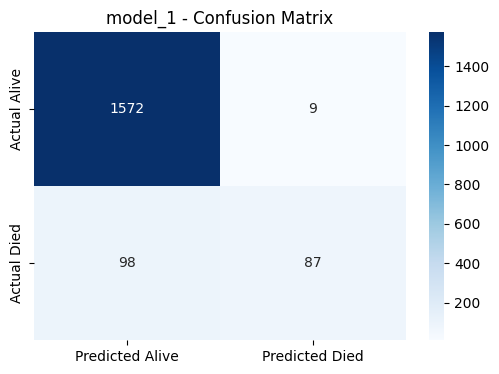


ROC-AUC Score: 0.7984


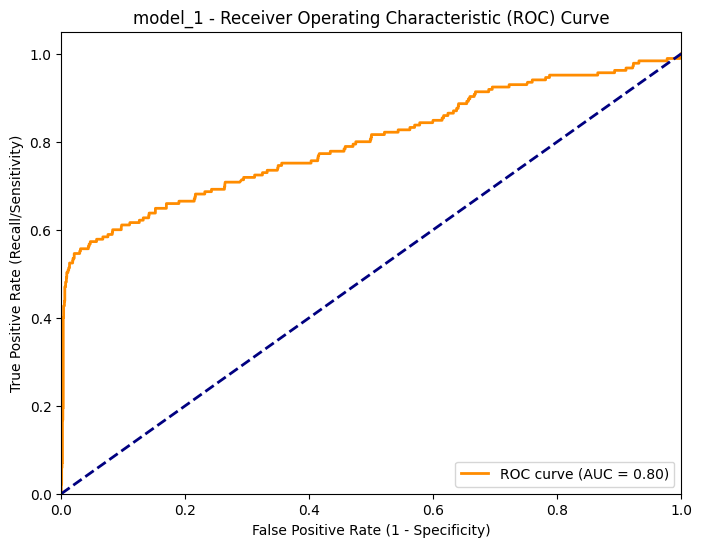

PR-AUC Score: 0.5957


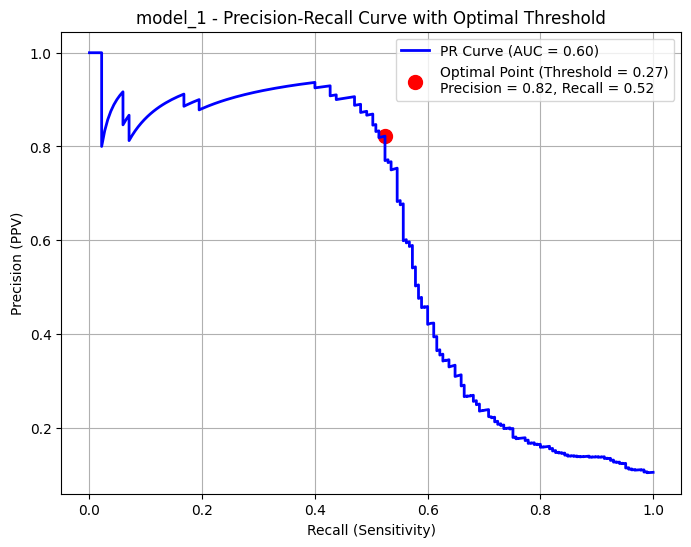


Classification Report at Optimal Threshold (0.27):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.82      0.52      0.64       185

    accuracy                           0.94      1766
   macro avg       0.88      0.76      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1560   21]
 [  88   97]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9867


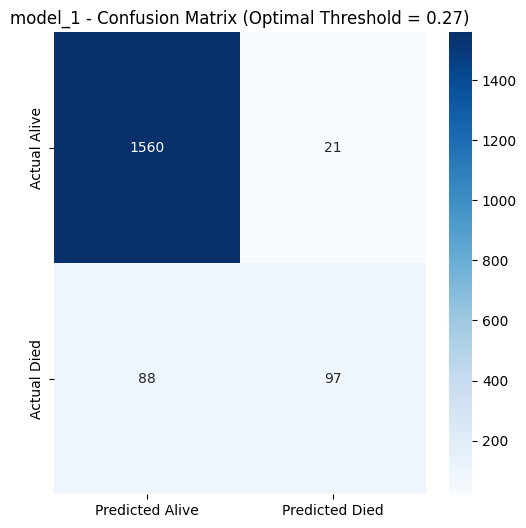

In [ ]:
evaluate_model_performance(y_test, y_pred1, y_proba1, model_name="model_1")

## Hyperparameter Tuning: RandomizedSearchCV

**Training**

In [ ]:
param_dist = {
    'C': np.logspace(-2, 2, 20),
    'gamma': np.logspace(-4, 0, 20),
    'kernel': ['rbf']
}

In [ ]:

svc_rs = RandomizedSearchCV(
    model_1, param_dist, n_iter=10,
    scoring='f1', cv=cv, n_jobs=-1,
    random_state=123, verbose=1
)

In [ ]:
svc_rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=SVC(probability=True, random_state=123), n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00...
                                        'gamma': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                                        'kernel': ['rbf']},
                   random_state=123, scoring='f1', verbose=1)

In [ ]:
print(f"Best parameters from RandomizedSearchCV: {svc_rs.best_params_}")
print(f"Best CV F1 Score from RS: {svc_rs.best_score_:.4f}")

Best parameters from RandomizedSearchCV: {'kernel': 'rbf', 'gamma': np.float64(0.08858667904100823), 'C': np.float64(2.06913808111479)}
Best CV F1 Score from RS: 0.6376


In [ ]:
best_svc_rs = svc_rs.best_estimator_
best_svc_rs.fit(X_train, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=np.float64(2.06913808111479), gamma=np.float64(0.08858667904100823),
    probability=True, random_state=123)

**Prediction**

In [ ]:
# Generate predictions and probabilities
y_pred2 = best_svc_rs.predict(X_test)
y_proba2 = best_svc_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_2 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.99      0.97      1581
    Died (1)       0.89      0.49      0.63       185

    accuracy                           0.94      1766
   macro avg       0.92      0.74      0.80      1766
weighted avg       0.94      0.94      0.93      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9930


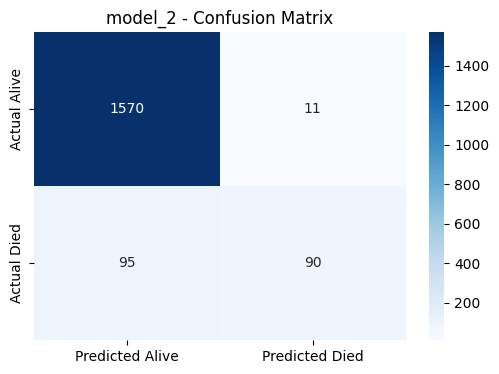


ROC-AUC Score: 0.7997


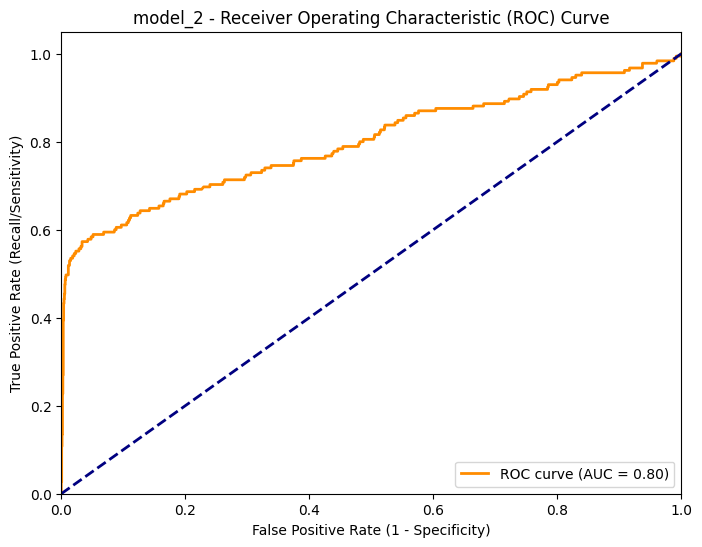

PR-AUC Score: 0.6121


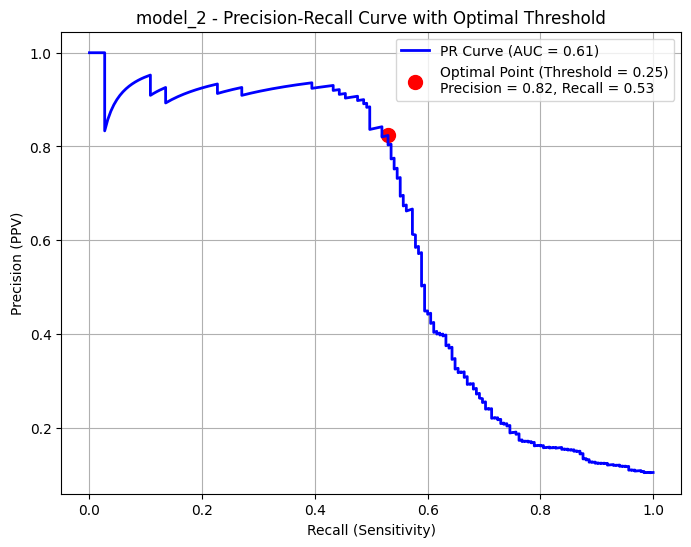


Classification Report at Optimal Threshold (0.25):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.82      0.53      0.64       185

    accuracy                           0.94      1766
   macro avg       0.89      0.76      0.81      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1560   21]
 [  87   98]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9867


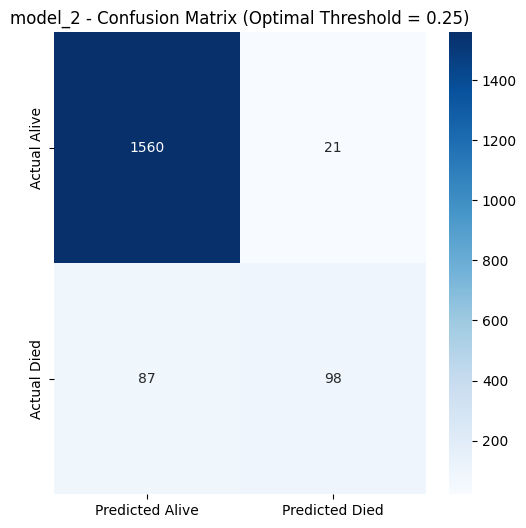

In [ ]:
evaluate_model_performance(y_test, y_pred2, y_proba2, model_name="model_2")

## Hyperparameter Tuning: Grid Search (GS)

**Training**

In [ ]:

param_grid = {
    'C': [0.1, 1, 10],           # Only 3 key values (instead of 10)
    'gamma': [0.001, 0.01, 0.1],  # Only 3 key values (instead of 10)
    'kernel': ['rbf']             # Skip 'poly' if RBF usually works
}

In [ ]:
svc_gs = GridSearchCV(
    model_1,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

In [ ]:
svc_gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=SVC(probability=True, random_state=123), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)

In [ ]:
print(f"Best parameters from GridSearchCV: {svc_gs.best_params_}")
print(f"Best CV F1 Score from GS: {svc_gs.best_score_:.4f}")

Best parameters from GridSearchCV: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV F1 Score from GS: 0.6630


In [ ]:
best_svc_gs = svc_gs.best_estimator_
best_svc_gs.fit(X_train, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, gamma=0.1, probability=True, random_state=123)

**Prediction**

In [ ]:
# Generate predictions and probabilities
y_pred3 = best_svc_gs.predict(X_test)
y_proba3 = best_svc_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_3 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.99      0.97      1581
    Died (1)       0.88      0.49      0.63       185

    accuracy                           0.94      1766
   macro avg       0.91      0.74      0.80      1766
weighted avg       0.94      0.94      0.93      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9924


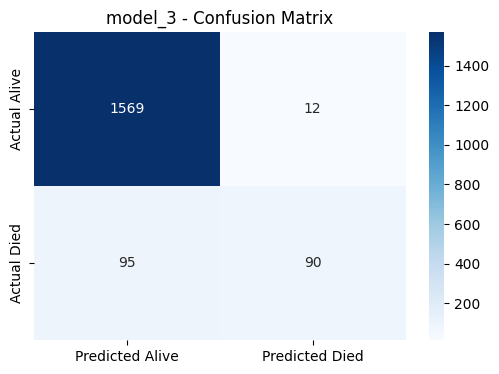


ROC-AUC Score: 0.7950


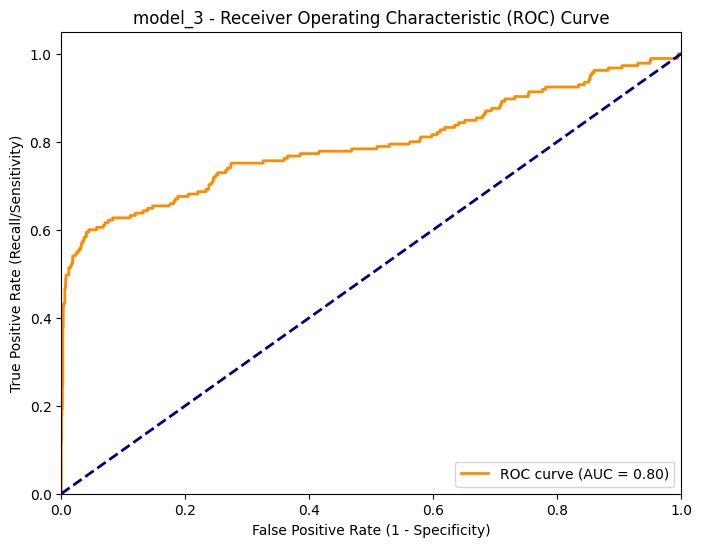

PR-AUC Score: 0.6283


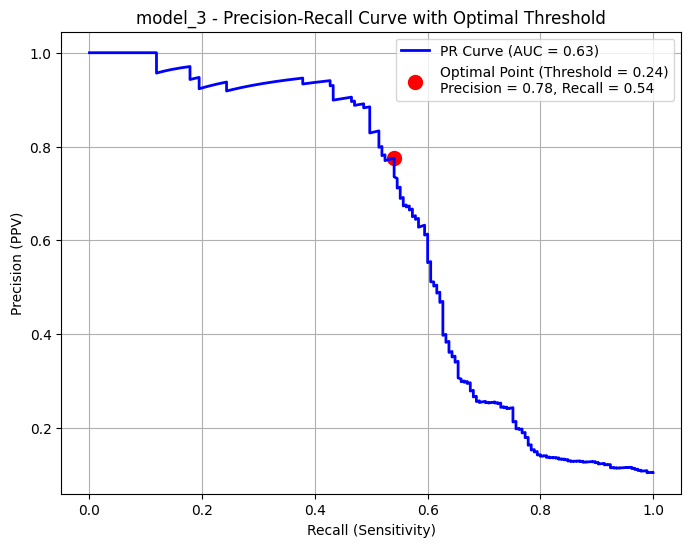


Classification Report at Optimal Threshold (0.24):
              precision    recall  f1-score   support

       Alive       0.95      0.98      0.96      1581
        Died       0.78      0.54      0.64       185

    accuracy                           0.94      1766
   macro avg       0.86      0.76      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1552   29]
 [  85  100]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9817


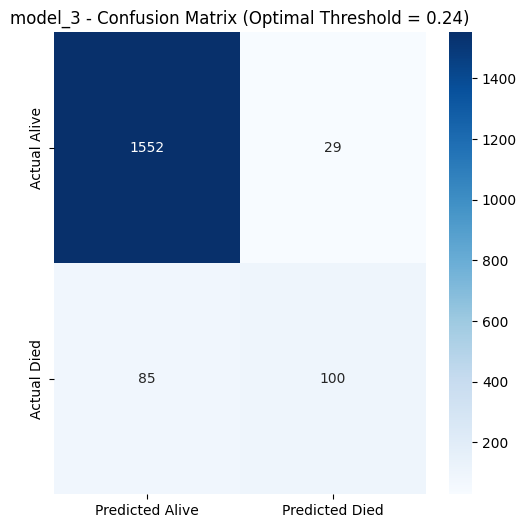

In [ ]:
evaluate_model_performance(y_test, y_pred3, y_proba3, model_name="model_3")

# Train the model after Balancing using SMOTE

##SMOTE Only

**Training**

In [ ]:


svc_os = make_pipeline(
    SMOTE(random_state=123),
    model_1
  )

In [ ]:
# Step 5: Train the model
svc_os.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('svc', SVC(probability=True, random_state=123))])

**Prediction**

In [ ]:
# Generate predictions and probabilities
y_os_pred1 = svc_os.predict(X_test)
y_os_proba1 = svc_os.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_4 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.91      0.93      1581
    Died (1)       0.42      0.56      0.48       185

    accuracy                           0.87      1766
   macro avg       0.68      0.73      0.70      1766
weighted avg       0.89      0.87      0.88      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9083


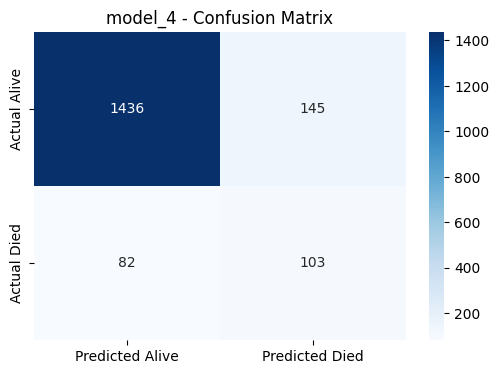


ROC-AUC Score: 0.7910


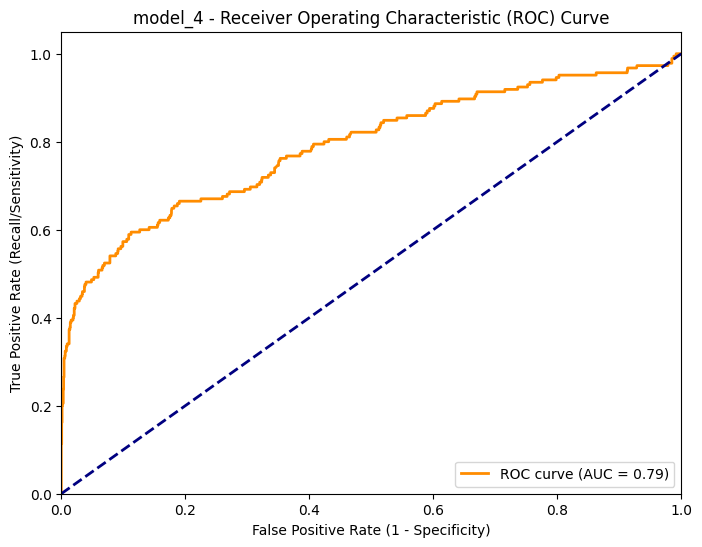

PR-AUC Score: 0.5435


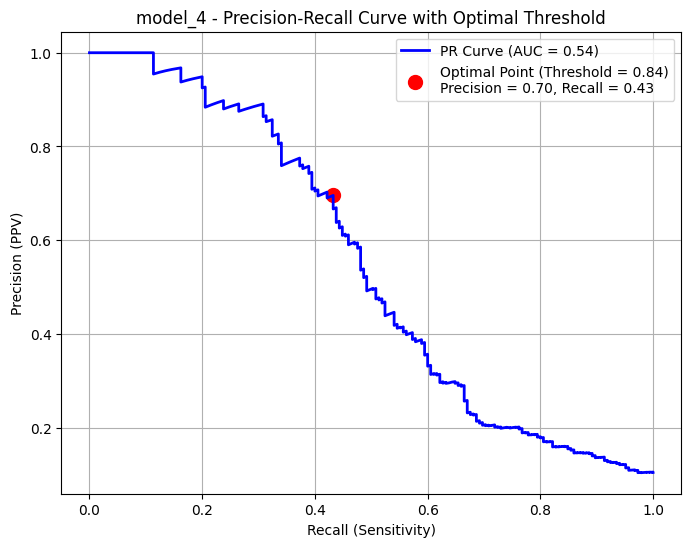


Classification Report at Optimal Threshold (0.84):
              precision    recall  f1-score   support

       Alive       0.94      0.98      0.96      1581
        Died       0.70      0.43      0.53       185

    accuracy                           0.92      1766
   macro avg       0.82      0.71      0.75      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1546   35]
 [ 105   80]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9779


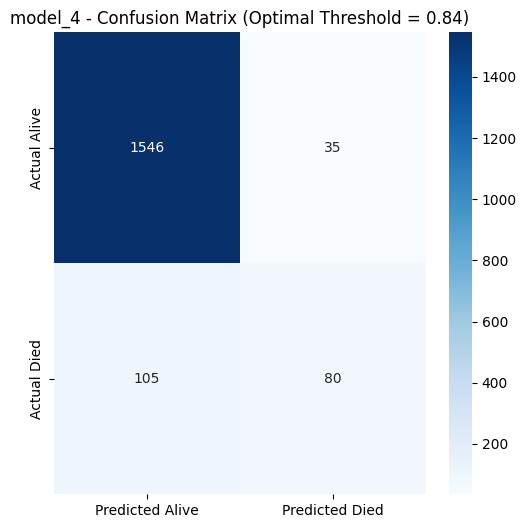

In [ ]:
evaluate_model_performance(y_test, y_os_pred1, y_os_proba1, model_name="model_4")

## SMOTE + RandomizedSearchCV

**Training**

In [ ]:

param_dist = {
    'svc__C': np.logspace(-3, 2, 50),
    'svc__gamma': np.logspace(-5, 1, 50),
    'svc__kernel': ['rbf', 'linear']
}

In [ ]:

svc_os_rs = RandomizedSearchCV(
    svc_os,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=123,
    verbose=1
)

In [ ]:
# Execute search
svc_os_rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=123))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03...
       2.68269580e-02, 3.55648031e-02, 4.71486636e-02, 6.25055193e-02,
       8.28642773e-02, 1.09854114e-01, 1.45634848e-01, 1.93069773e-01,
       2.55954792e-01, 3.39322177e-01, 4.49843267e-01, 5.96362332e-01,
       7.90604321e-01, 1.04811313e+00, 1.38949549e+00, 1.84206997e+00,
       2.44205309e+00, 3.23745754e+00, 4.29193426e+00, 5.68986603e+00,
       7.54312006e+00, 1.00000000e+01]),
                                        'svc__kernel': ['rbf', 'linear']},
                   random_state=123, scoring='f1', verbose=1)

In [ ]:

print(f"\nBest params from RS: {svc_os_rs.best_params_}")
print(f"Best CV F1 Score from RS: {svc_os_rs.best_score_:.4f}")


Best params from RS: {'svc__kernel': 'rbf', 'svc__gamma': np.float64(0.020235896477251575), 'svc__C': np.float64(2.9470517025518097)}
Best CV F1 Score from RS: 0.4689


In [ ]:
best_svc_os_rs = svc_os_rs.best_estimator_
best_svc_os_rs.fit(X_train, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('svc',
                 SVC(C=np.float64(2.9470517025518097),
                     gamma=np.float64(0.020235896477251575), probability=True,
                     random_state=123))])

**Prediction**

In [ ]:
# --- Classification Evaluation ---
y_os_pred2 = best_svc_os_rs.predict(X_test)
y_os_proba2 = best_svc_os_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_5 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.91      0.93      1581
    Died (1)       0.43      0.57      0.49       185

    accuracy                           0.88      1766
   macro avg       0.69      0.74      0.71      1766
weighted avg       0.89      0.88      0.88      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9121


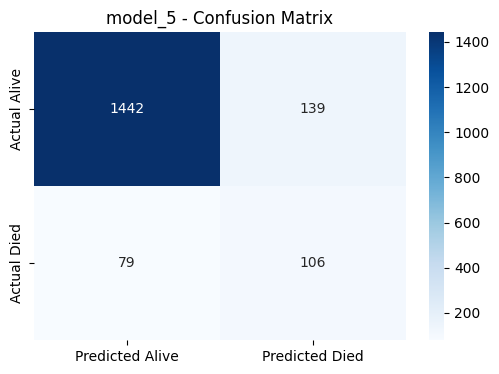


ROC-AUC Score: 0.7962


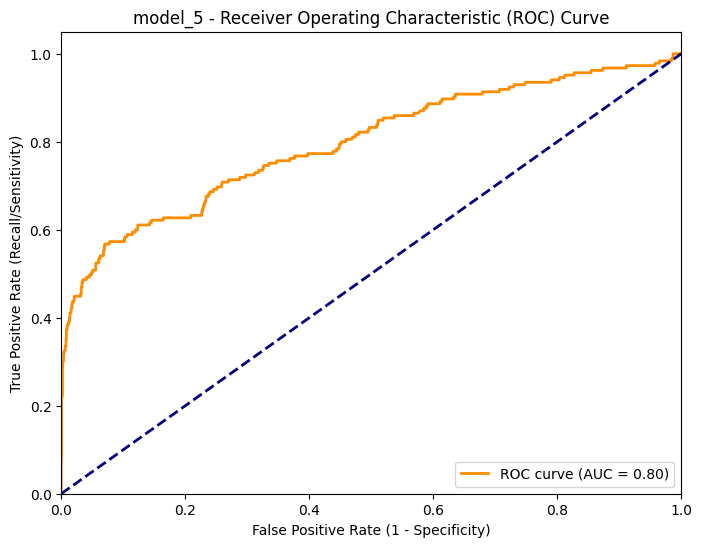

PR-AUC Score: 0.5647


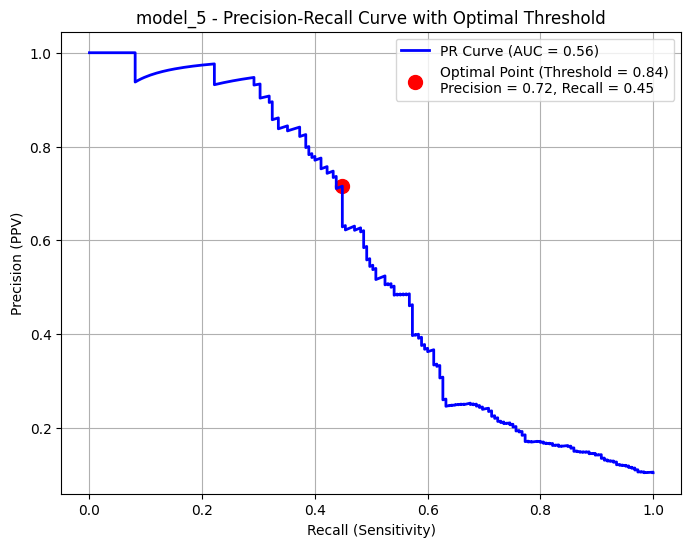


Classification Report at Optimal Threshold (0.84):
              precision    recall  f1-score   support

       Alive       0.94      0.98      0.96      1581
        Died       0.72      0.45      0.55       185

    accuracy                           0.92      1766
   macro avg       0.83      0.71      0.75      1766
weighted avg       0.91      0.92      0.92      1766

Confusion Matrix at Optimal Threshold:
[[1548   33]
 [ 102   83]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9791


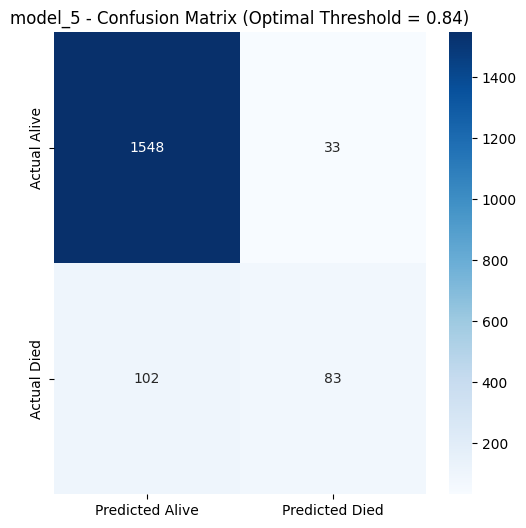

In [ ]:
evaluate_model_performance(y_test, y_os_pred2, y_os_proba2, model_name="model_5")

## SMOTE + GridSearchCV

**Training**

In [ ]:
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1]
}

In [ ]:
svc_os_gs = GridSearchCV(
    svc_os,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose = 1
  )

In [ ]:
svc_os_gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=123))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__gamma': [0.001, 0.01, 0.1]},
             verbose=1)

In [ ]:

print(f"Best parameters: {svc_os_gs.best_params_}")
print(f"Best CV F1 score: {svc_os_gs.best_score_:.4f}")

Best parameters: {'svc__C': 0.1, 'svc__gamma': 0.1}
Best CV F1 score: 0.8634


In [ ]:
best_svc_os_gs = svc_os_gs.best_estimator_
best_svc_os_gs.fit(X_train, y_train)  # No eval_set here

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('svc',
                 SVC(C=0.1, gamma=0.1, probability=True, random_state=123))])

**Prediction**

In [ ]:

y_os_pred3 = best_svc_os_gs.predict(X_test)
y_os_proba3 = best_svc_os_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_6 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.94      0.92      0.93      1581
    Died (1)       0.43      0.52      0.47       185

    accuracy                           0.88      1766
   macro avg       0.69      0.72      0.70      1766
weighted avg       0.89      0.88      0.88      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9184


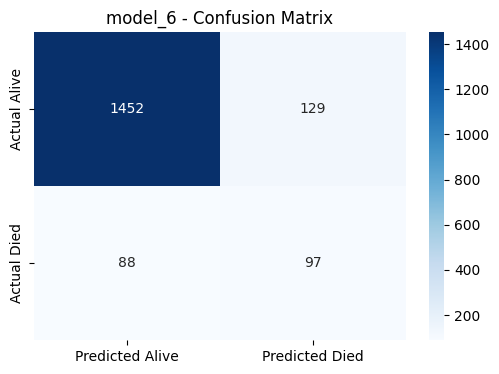


ROC-AUC Score: 0.7876


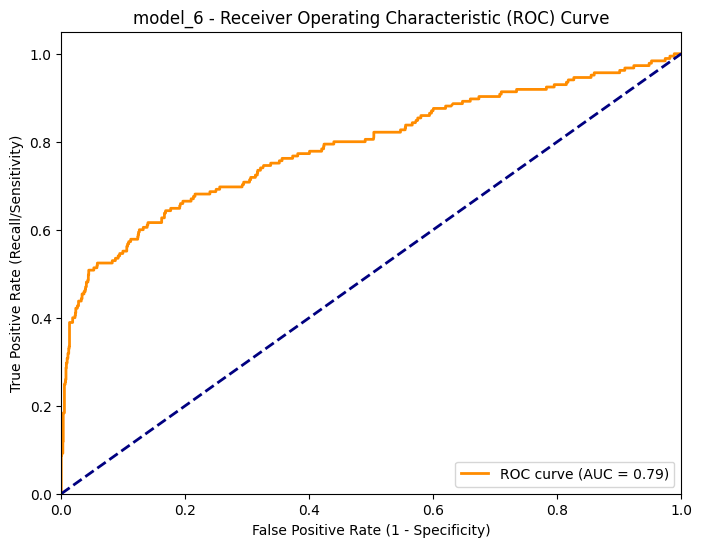

PR-AUC Score: 0.5196


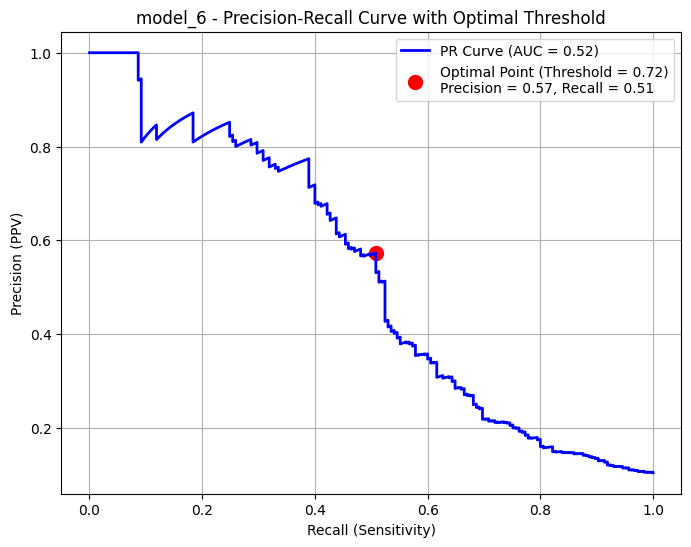


Classification Report at Optimal Threshold (0.72):
              precision    recall  f1-score   support

       Alive       0.94      0.96      0.95      1581
        Died       0.57      0.51      0.54       185

    accuracy                           0.91      1766
   macro avg       0.76      0.73      0.74      1766
weighted avg       0.90      0.91      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1511   70]
 [  91   94]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9557


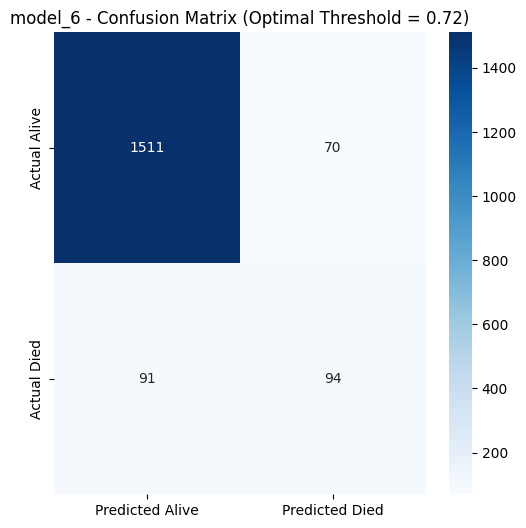

In [ ]:
evaluate_model_performance(y_test, y_os_pred3, y_os_proba3, model_name="model_6")

# Train the model after Balancing using Undersampling.

## Undersampling Only

**Training**

In [ ]:
svc_us = make_pipeline(
    RandomUnderSampler(random_state=123),
    model_1
)

In [ ]:

svc_us.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=123)),
                ('svc', SVC(probability=True, random_state=123))])

**Prediction**

In [ ]:
y_us_pred1 = svc_us.predict(X_test)
y_us_proba1 = svc_us.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_7 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.93      0.94      1581
    Died (1)       0.52      0.60      0.56       185

    accuracy                           0.90      1766
   macro avg       0.74      0.77      0.75      1766
weighted avg       0.91      0.90      0.90      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9349


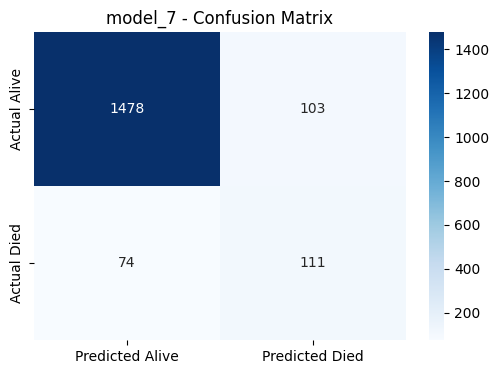


ROC-AUC Score: 0.7848


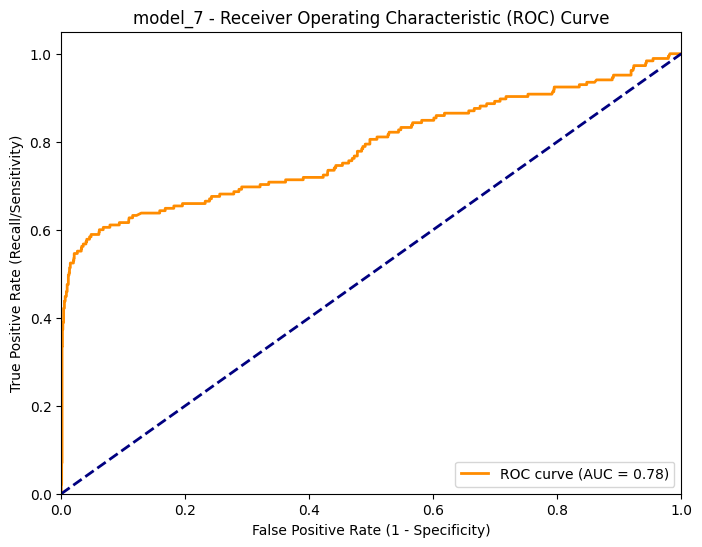

PR-AUC Score: 0.6071


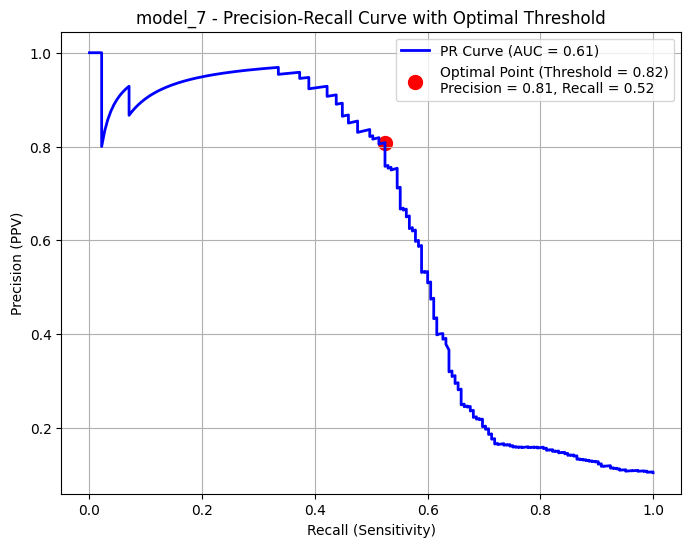


Classification Report at Optimal Threshold (0.82):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.81      0.52      0.64       185

    accuracy                           0.94      1766
   macro avg       0.88      0.75      0.80      1766
weighted avg       0.93      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1558   23]
 [  88   97]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9855


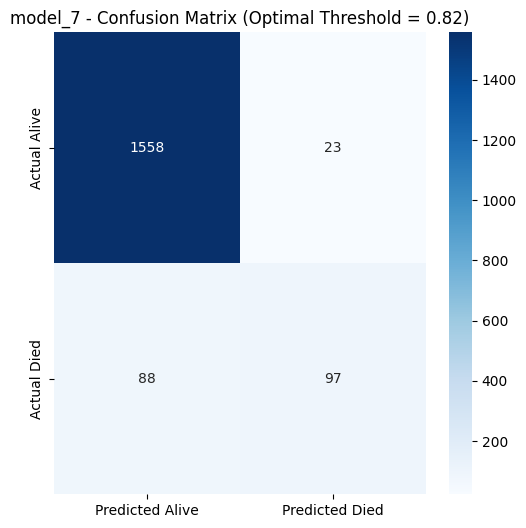

In [ ]:
evaluate_model_performance(y_test, y_us_pred1, y_us_proba1, model_name="model_7")

## Undersampling + RandomizedSearchCV

**Training**

In [ ]:
param_dist = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.01, 0.1],

}

In [ ]:

svc_us_rs = RandomizedSearchCV(
    svc_us,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=123,
    verbose=1
)

In [ ]:

svc_us_rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('randomundersampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': [0.1, 1, 10, 100],
                                        'svc__gamma': ['scale', 'auto', 0.01,
                                                       0.1]},
                   random_state=123, scoring='roc_auc', verbose=1)

In [ ]:
print(f"\nBest params from RS: {svc_us_rs.best_params_}")
print(f"Best CV F1 Score from RS: {svc_us_rs.best_score_:.4f}")


Best params from RS: {'svc__gamma': 'auto', 'svc__C': 1}
Best CV F1 Score from RS: 0.8066


In [ ]:
best_svc_us_rs = svc_us_rs.best_estimator_
best_svc_us_rs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=123)),
                ('svc',
                 SVC(C=1, gamma='auto', probability=True, random_state=123))])

**Prediction**

In [ ]:

y_us_pred2 = best_svc_us_rs.predict(X_test)
y_us_proba2 = best_svc_us_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_8 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.92      0.94      1581
    Died (1)       0.47      0.59      0.52       185

    accuracy                           0.89      1766
   macro avg       0.71      0.76      0.73      1766
weighted avg       0.90      0.89      0.89      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9209


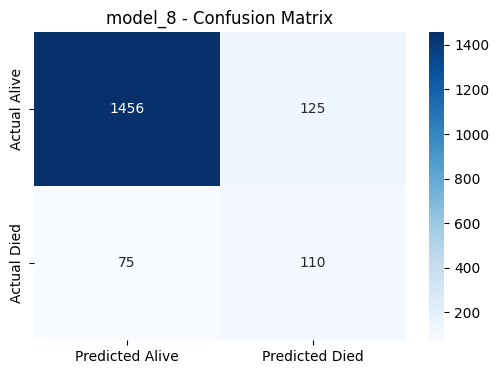


ROC-AUC Score: 0.7842


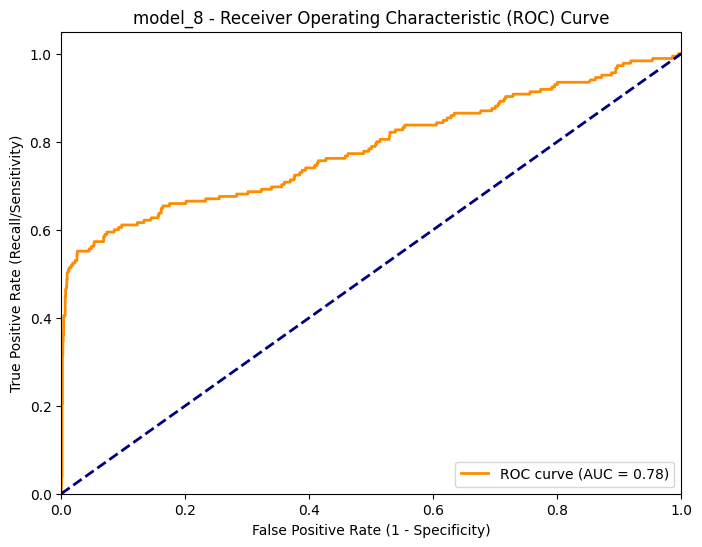

PR-AUC Score: 0.5936


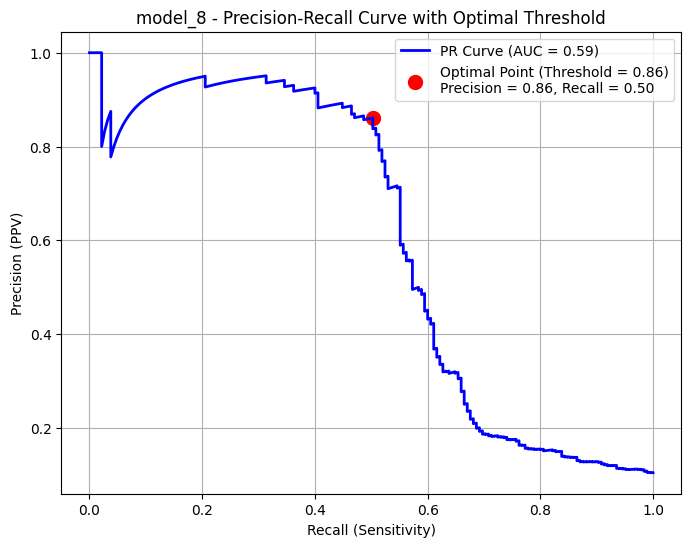


Classification Report at Optimal Threshold (0.86):
              precision    recall  f1-score   support

       Alive       0.94      0.99      0.97      1581
        Died       0.86      0.50      0.63       185

    accuracy                           0.94      1766
   macro avg       0.90      0.75      0.80      1766
weighted avg       0.94      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1566   15]
 [  92   93]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9905


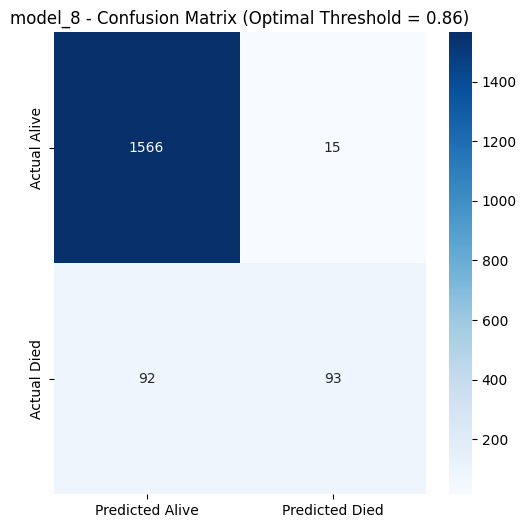

In [ ]:
evaluate_model_performance(y_test, y_us_pred2, y_us_proba2, model_name="model_8")

## Undersampling + GridSearchCV

**Training**

In [ ]:
param_grid = {
    'randomundersampler__sampling_strategy': [0.7],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.1, 0.01]
}

In [ ]:
svc_us_gs = GridSearchCV(
    svc_us,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [ ]:

svc_us_gs.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=123)),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=123))]),
             n_jobs=-1,
             param_grid={'randomundersampler__sampling_strategy': [0.7],
                         'svc__C': [0.1, 1, 10],
                         'svc__gamma': ['scale', 0.1, 0.01]},
             scoring='roc_auc', verbose=1)

In [ ]:

print(f"\nBest params: {svc_us_gs.best_params_}")
print(f"Best CV F1: {svc_us_gs.best_score_:.4f}")


Best params: {'randomundersampler__sampling_strategy': 0.7, 'svc__C': 1, 'svc__gamma': 0.1}
Best CV F1: 0.8088


In [ ]:
best_svc_us_gs = svc_us_gs.best_estimator_
best_svc_us_gs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=123, sampling_strategy=0.7)),
                ('svc',
                 SVC(C=1, gamma=0.1, probability=True, random_state=123))])

**Prediction**

In [ ]:
y_us_pred3 = best_svc_us_gs.predict(X_test)
y_us_proba3 = best_svc_us_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_9 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.96      0.96      1581
    Died (1)       0.63      0.57      0.60       185

    accuracy                           0.92      1766
   macro avg       0.79      0.77      0.78      1766
weighted avg       0.92      0.92      0.92      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9608


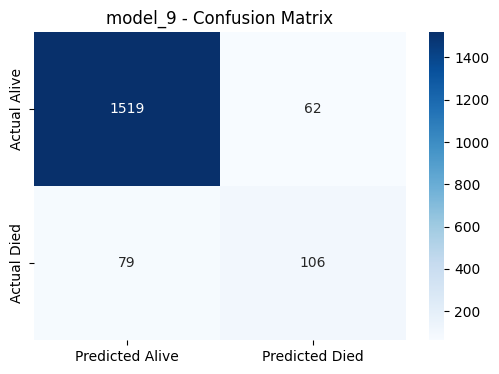


ROC-AUC Score: 0.7886


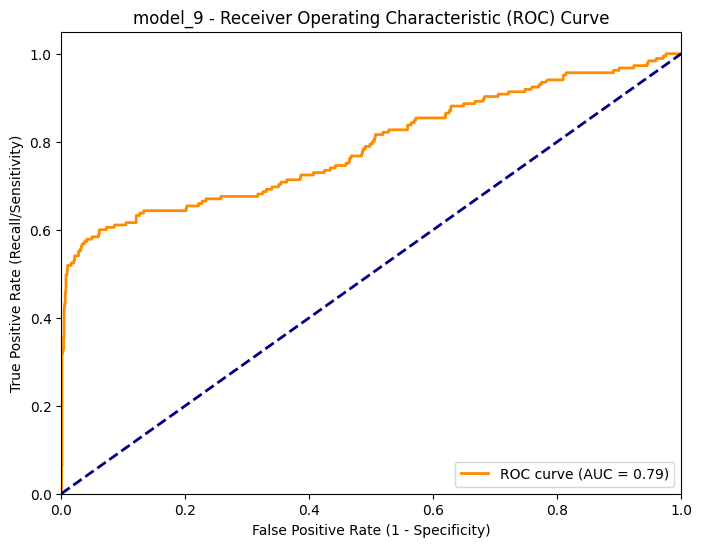

PR-AUC Score: 0.6016


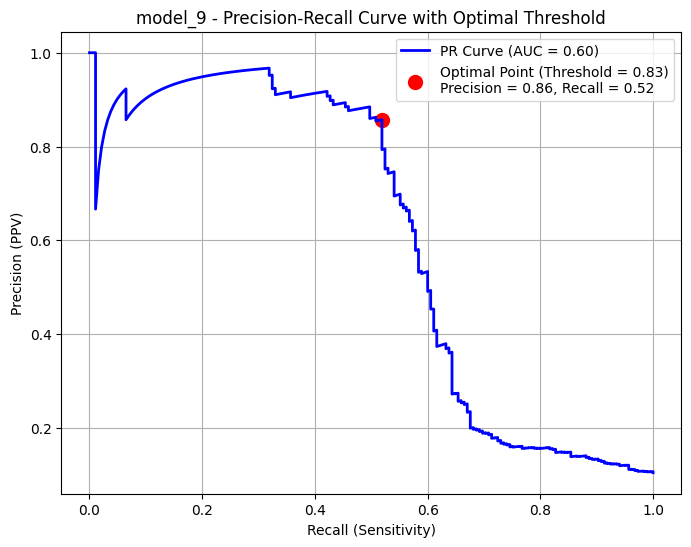


Classification Report at Optimal Threshold (0.83):
              precision    recall  f1-score   support

       Alive       0.95      0.99      0.97      1581
        Died       0.86      0.52      0.65       185

    accuracy                           0.94      1766
   macro avg       0.90      0.75      0.81      1766
weighted avg       0.94      0.94      0.93      1766

Confusion Matrix at Optimal Threshold:
[[1565   16]
 [  89   96]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9899


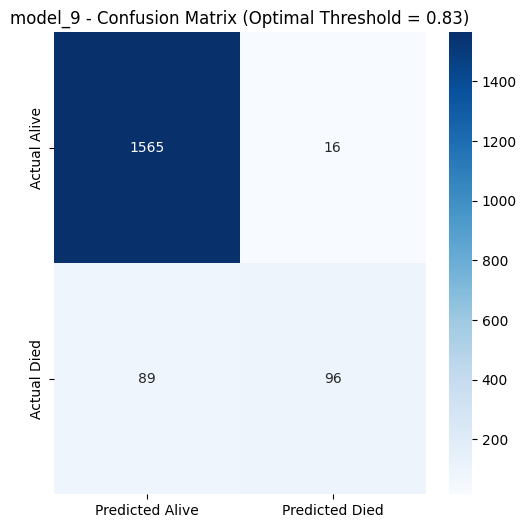

In [ ]:
evaluate_model_performance(y_test, y_us_pred3, y_us_proba3, model_name="model_9")

# Train the model after Balancing using Hybrid

##Hybrid Only

**Training**

In [ ]:
svc_hy = make_pipeline(
    SMOTE(random_state=123),
    RandomUnderSampler(random_state=123),
    model_1
)

In [ ]:


svc_hy.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('smote', SMOTE(random_state=123)),
                ('randomundersampler', RandomUnderSampler(random_state=123)),
                ('svc', SVC(probability=True, random_state=123))])

**Prediction**

In [ ]:

y_hy_pred1= svc_hy.predict(X_test)
y_hy_proba1 = svc_hy.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_10 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.91      0.93      1581
    Died (1)       0.42      0.56      0.48       185

    accuracy                           0.87      1766
   macro avg       0.68      0.73      0.70      1766
weighted avg       0.89      0.87      0.88      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9083


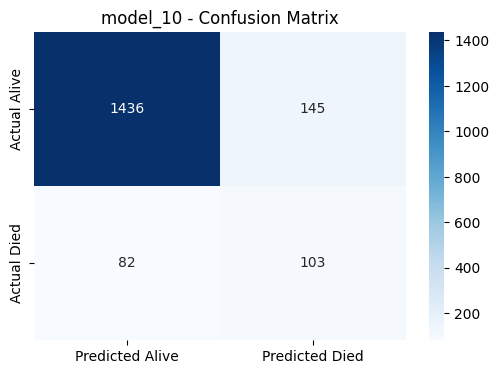


ROC-AUC Score: 0.7908


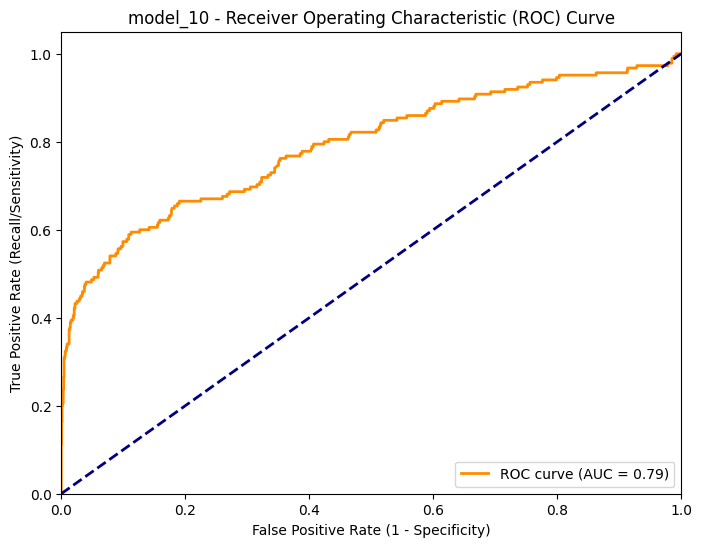

PR-AUC Score: 0.5434


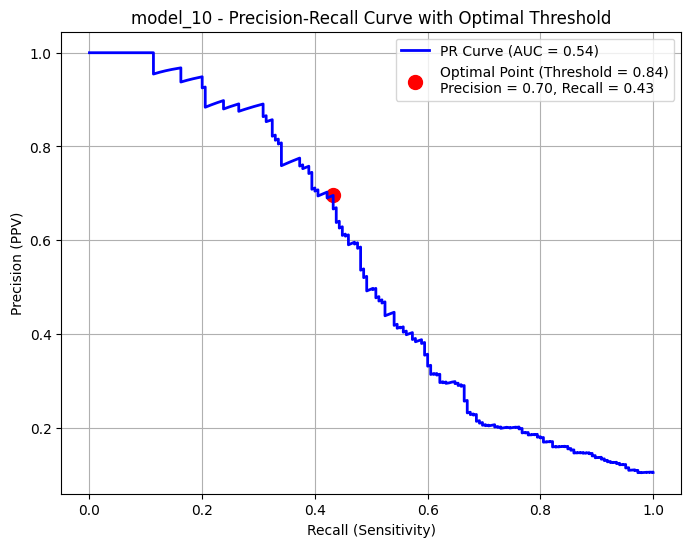


Classification Report at Optimal Threshold (0.84):
              precision    recall  f1-score   support

       Alive       0.94      0.98      0.96      1581
        Died       0.70      0.43      0.53       185

    accuracy                           0.92      1766
   macro avg       0.82      0.71      0.75      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1546   35]
 [ 105   80]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9779


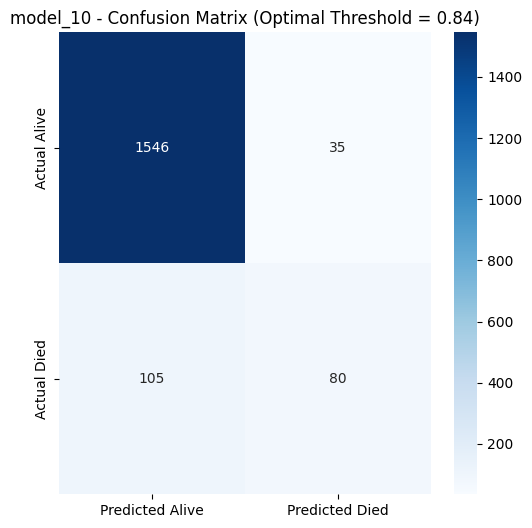

In [ ]:
evaluate_model_performance(y_test, y_hy_pred1, y_hy_proba1, model_name="model_10")

## Hybrid + RS

**Training**

In [ ]:
param_dist = {
    'svc__C': np.logspace(-1, 1, 10),  # More focused range (0.1 to 10), fewer points
    'svc__gamma': np.logspace(-2, 0, 10), # More focused range (0.01 to 1), fewer points
    'svc__kernel': ['rbf'],             # Focus on the 'rbf' kernel, as it performed well in previous models
    'smote__sampling_strategy': np.linspace(0.5, 1.0, 4), # Reduce number of options
    'randomundersampler__sampling_strategy': [1.0] # Fixed to 1.0 to ensure proper balancing and avoid error
}

In [ ]:
svc_hy_rs = RandomizedSearchCV(
    estimator=svc_hy,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=123,
    error_score='raise'
)

In [ ]:
print("\nRunning RandomizedSearchCV...")
svc_hy_rs.fit(X_train, y_train)


Running RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                             ('randomundersampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=123))]),
                   n_jobs=-1,
                   param_distributions={'randomundersampler__sampling_strategy': [1.0],
                                        'smo...ampling_strategy': array([0.5       , 0.66666667, 0.83333333, 1.        ]),
                                        'svc__C': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
                                        'svc__gamma': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                                        'svc__kernel': ['rbf']},
                   random_state=123, scoring='f1', verbose=2)

In [ ]:

print("\nBest Params:", svc_hy_rs.best_params_)
print("Best CV F1 Score:", svc_hy_rs.best_score_)


Best Params: {'svc__kernel': 'rbf', 'svc__gamma': np.float64(0.027825594022071243), 'svc__C': np.float64(0.774263682681127), 'smote__sampling_strategy': np.float64(0.5), 'randomundersampler__sampling_strategy': 1.0}
Best CV F1 Score: 0.5118199881086479


In [ ]:
best_svc_hy_rs = svc_hy_rs.best_estimator_
best_svc_hy_rs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('smote',
                 SMOTE(random_state=123, sampling_strategy=np.float64(0.5))),
                ('randomundersampler',
                 RandomUnderSampler(random_state=123, sampling_strategy=1.0)),
                ('svc',
                 SVC(C=np.float64(0.774263682681127),
                     gamma=np.float64(0.027825594022071243), probability=True,
                     random_state=123))])

**Prediction**

In [ ]:

y_hy_pred2 = best_svc_hy_rs.predict(X_test)
y_hy_proba2 = best_svc_hy_rs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_11 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.92      0.93      1581
    Died (1)       0.46      0.59      0.52       185

    accuracy                           0.88      1766
   macro avg       0.71      0.76      0.73      1766
weighted avg       0.90      0.88      0.89      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9184


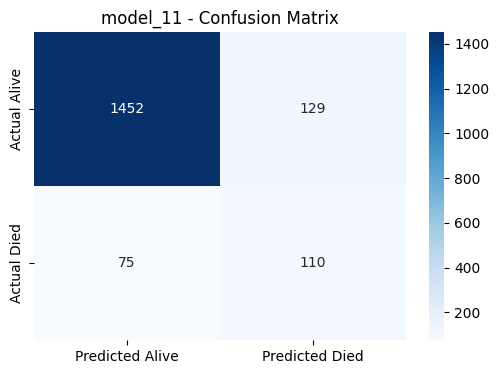


ROC-AUC Score: 0.7948


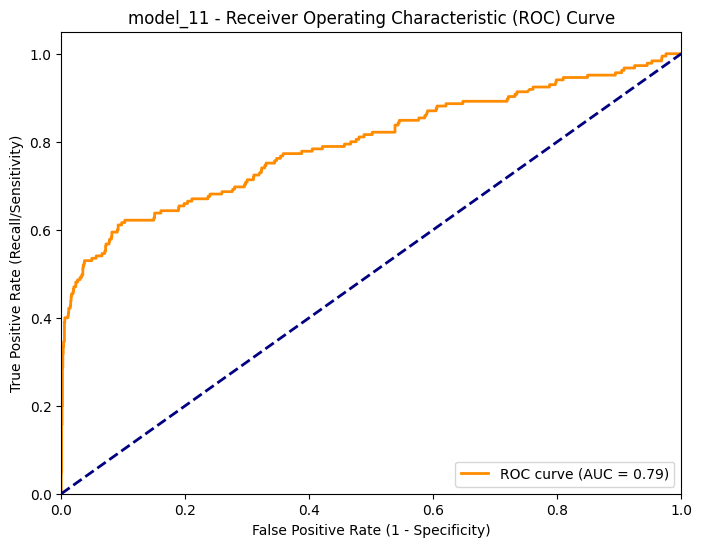

PR-AUC Score: 0.5800


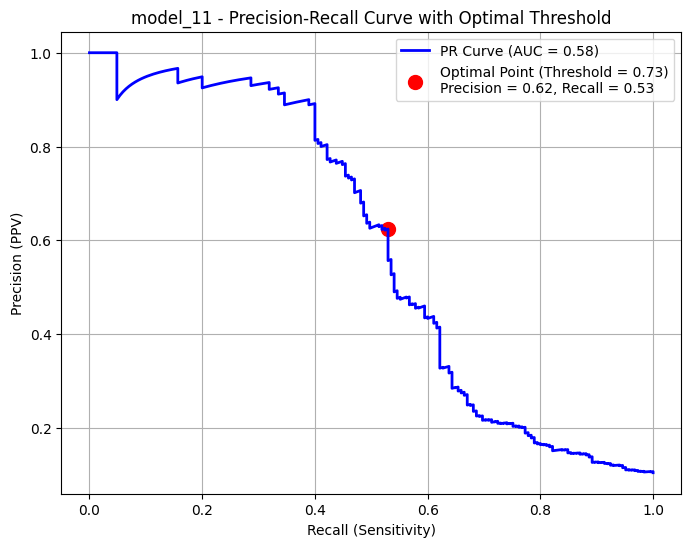


Classification Report at Optimal Threshold (0.73):
              precision    recall  f1-score   support

       Alive       0.95      0.96      0.95      1581
        Died       0.62      0.53      0.57       185

    accuracy                           0.92      1766
   macro avg       0.79      0.75      0.76      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1522   59]
 [  87   98]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9627


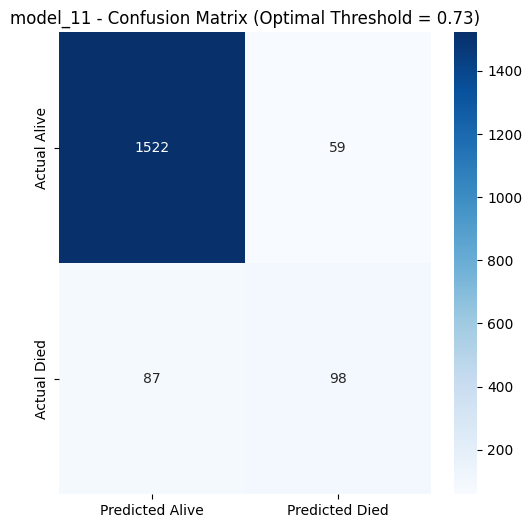

In [ ]:
evaluate_model_performance(y_test, y_hy_pred2, y_hy_proba2, model_name="model_11")

## Hybrid + GS

**Training**

In [ ]:
param_grid = {
    'svc__C': [0.5, 1, 2],
    'svc__gamma': ['scale'],
    'smote__sampling_strategy': [0.75],
    'randomundersampler__sampling_strategy': [0.5, 1.0]
}

In [ ]:
svc_hy_gs = GridSearchCV(
    estimator=svc_hy,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [ ]:

print("Running GridSearchCV...")
svc_hy_gs.fit(X_train, y_train)

Running GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/imblearn/pipeline.py", line 514, in fit
    Xt, yt = self._fit(X, y, routed_params

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=123)),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=123))]),
             n_jobs=-1,
             param_grid={'randomundersampler__sampling_strategy': [0.5, 1.0],
                         'smote__sampling_strategy': [0.75],
                         'svc__C': [0.5, 1, 2], 'svc__gamma': ['scale']},
             scoring='f1', verbose=2)

In [ ]:

print("\nBest Params:", svc_hy_gs.best_params_)
print("Best CV F1 Score:", svc_hy_gs.best_score_)


Best Params: {'randomundersampler__sampling_strategy': 1.0, 'smote__sampling_strategy': 0.75, 'svc__C': 0.5, 'svc__gamma': 'scale'}
Best CV F1 Score: 0.4624092575170036


In [ ]:
best_svc_hy_gs = svc_hy_gs.best_estimator_
best_svc_hy_gs.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('smote', SMOTE(random_state=123, sampling_strategy=0.75)),
                ('randomundersampler',
                 RandomUnderSampler(random_state=123, sampling_strategy=1.0)),
                ('svc', SVC(C=0.5, probability=True, random_state=123))])

**Prediction**

In [ ]:

y_hy_pred3 = best_svc_hy_gs.predict(X_test)
y_hy_proba3 = best_svc_hy_gs.predict_proba(X_test)[:, 1]

**Evaluation**


==================== Evaluation for model_12 ====================

Classification Report:
              precision    recall  f1-score   support

   alive (0)       0.95      0.92      0.93      1581
    Died (1)       0.45      0.56      0.50       185

    accuracy                           0.88      1766
   macro avg       0.70      0.74      0.72      1766
weighted avg       0.89      0.88      0.89      1766


Confusion Matrix:
Specificity (True Negative Rate): 0.9203


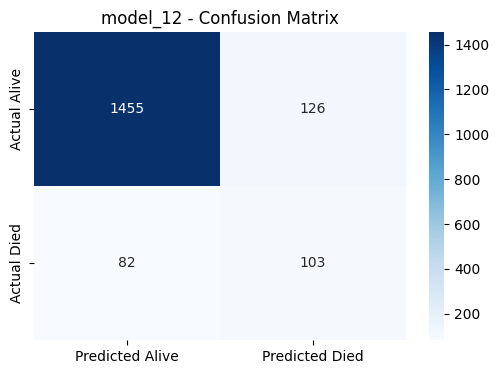


ROC-AUC Score: 0.7974


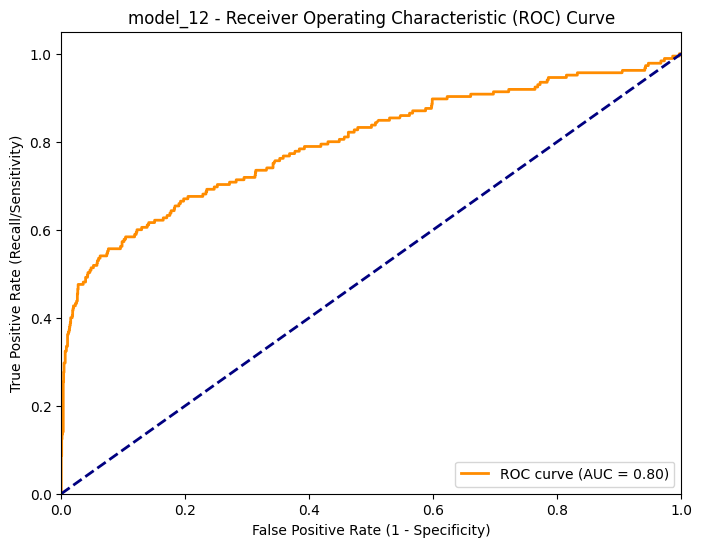

PR-AUC Score: 0.5476


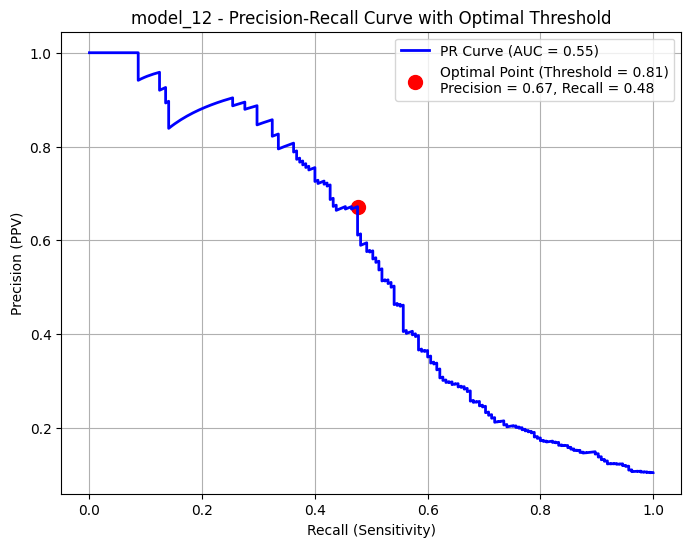


Classification Report at Optimal Threshold (0.81):
              precision    recall  f1-score   support

       Alive       0.94      0.97      0.96      1581
        Died       0.67      0.48      0.56       185

    accuracy                           0.92      1766
   macro avg       0.81      0.72      0.76      1766
weighted avg       0.91      0.92      0.91      1766

Confusion Matrix at Optimal Threshold:
[[1538   43]
 [  97   88]]
Specificity (True Negative Rate) at Optimal Threshold: 0.9728


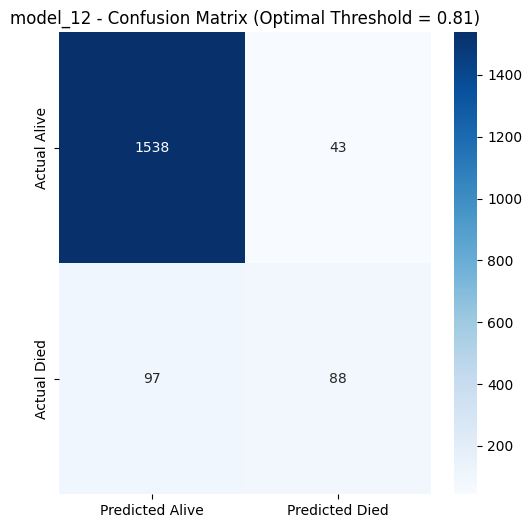

In [ ]:
evaluate_model_performance(y_test, y_hy_pred3, y_hy_proba3, model_name="model_12")

#Overfitting Assessment

Compute training and test accuracy to check for overfitting

In [ ]:
# Predict on training data
y_o_train_pred = best_svc_us_gs.predict(X_train)
train_accuracy = accuracy_score(y_train, y_o_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on test data
y_o_test_pred = best_svc_us_gs.predict(X_test)
test_accuracy = accuracy_score(y_test, y_o_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare: If train >> test, potential overfitting
if train_accuracy - test_accuracy > 0.05:  # Arbitrary threshold; adjust based on domain
    print("Warning: Model may be overfitting (large gap between train and test accuracy).")
else:
    print("Model appears well-generalized.")